## Presentación

Estos ejercicios tienen el fin de poder evaluar la situación en la que se encuentra cada unx de ustedes a esta altura de la materia. No es un examen, ni llevará ningún tipo de nota.

Les pedimos que respeten al pie de la letra el nombre de las funciones que les damos para completar y su "signature". Esto es, que respeten los argumentos de entrada y la salida. Esto es porque tenemos una forma de verificación automática que de otra manera no funciona. Cuando hayamos recibido los notebooks, haremos público el código de control.

Por supuesto, si quieren agregar celdas y más código, si quieren hacer pruebas para asegurarse de que el código funciona, etc., pueden hacerlo aquí mismo.

La _modalidad de entrega preferencial_ es a través de GitHub:
1. Hacer un fork del [repositorio](https://github.com/exord/UNSAM_IA), tocando el botón de arriba a la derecha (ver figura). 

2. Crear un subdirectorio dentro del directorio <tt>entregas</tt> con el formato "ApellidoNombre"
3. Completar este notebook y colocarlo en ese directorio. Hacer un "commit" y un "push" a su versión del repositorio.
4. Realizar un <tt>pull request</tt> desde GitHub y seguir las instrucciones. Más información en la [página de GitHub](https://help.github.com/en/github/collaborating-with-issues-and-pull-requests/about-pull-requests).

De ser necesario, en caso de sufrir de **alergia severa a GitHub**, el notebook puede enviarse por email.

La **fecha límite** para la entrega es el **martes 21 de abril a las 20 horas**.

<figure>
    <img src="figures/fork_pullrequest.jpeg", alt="Fork", width="800px", 
         style="float: left; margin-right: 10px;"/>
    
     <figcaption>Fig.1 - Ubicación de los botones para Fork y Pull request en Github.</figcaption>
</figure>

## 1. Probabilidad Condicional

In [1]:
#Si estas en Google Colab, ejecuta esta celda una unica vez:
!mkdir datasets
!mkdir datasets/student-alcohol-consumption
!wget https://raw.githubusercontent.com/exord/UNSAM_IA/master/datasets/student-alcohol-consumption/student-mat.csv
!mv student-mat.csv datasets/student-alcohol-consumption/student-mat.csv

mkdir: cannot create directory ‘datasets’: File exists
mkdir: cannot create directory ‘datasets/student-alcohol-consumption’: File exists
--2020-04-21 12:06:22--  https://raw.githubusercontent.com/exord/UNSAM_IA/master/datasets/student-alcohol-consumption/student-mat.csv
Resolving raw.githubusercontent.com... 151.101.216.133
Connecting to raw.githubusercontent.com|151.101.216.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41983 (41K) [text/plain]
Saving to: ‘student-mat.csv’

student-mat.csv     100%[===================>]  41,00K   207KB/s    in 0,2s    

2020-04-21 12:06:23 (207 KB/s) - ‘student-mat.csv’ saved [41983/41983]



Similar al ***Caso: Apruebo si falto a clase?*** del [notebook de probabilidad condicional](02_Condicional.ipynb), calcule la probabilidad de que un alumno haya faltado menos de 3 veces dado que sacó más de un 60% en la materia, i.e.
$$
P( \text{absences} < 3 | \text{G3} \geq 12).
$$

Por favor, utilice el siguiente signature. Se recomienda cambiar el código solamente entre los comentarios "Start" y "Finish". 
Si quiere probar cosas, siéntase libre de crear nuevas celdas de código, aunque estas no serán evaluadas.

In [2]:
import numpy as np
import pandas as pd

def prob_condicional(df=pd.read_csv('datasets/student-alcohol-consumption/student-mat.csv')):
    """Calcula P(absences < 3 | G3 >= 12).
    Input:
    df -- dataset de estudiantes
    Output:
    p        -- probabilidad de que absences > 3 dado que G3 >= 12
    """
    #Start

    #print(df.describe())
    print("Cantidad de registros: {}".format(len(df)))
    df['aprueba'] = np.where(df['G3'] >= 12, 1, 0)
    print('Aprobaron: {}'.format(sum(df['aprueba'])))
    df['falto_poco'] = np.where(df['absences'] < 3, 1, 0)
    print('Faltaron poco: {}'.format(sum(df['falto_poco'])))
    
    df['cuenta'] = 1
    df = df[['aprueba','falto_poco','cuenta']]
    #print(df.keys())
    
    df2 = pd.pivot_table(df, values = 'cuenta', index = ['aprueba'], 
                         columns = ['falto_poco'], aggfunc = np.sum, fill_value = 0)
    print(df2)
    
    p_abs_and_apr = (df2.values[1,1])/len(df)
    p_apr = (df2.values[1,0]+df2.values[1,1])/len(df)
    p_abs_apr = p_abs_and_apr / p_apr # p(abs|apr) = p(abs&apr) / p(apr)
    #guarda el valor final, como un número, en esta variable
    resultado = p_abs_apr
    #Finish
    return resultado

#prob_condicional()

Cantidad de registros: 395
Aprobaron: 162
Faltaron poco: 183
falto_poco    0    1
aprueba             
0           131  102
1            81   81


0.5

## 2. Inferencia Bayesiana

Se tira una moneda N veces, de las cuales X sale cara. La moneda sale cara con una frecuencia $\mu$ desconocida, pero que se cree que es *fair*. 

Construya una función que recibe el vector con los N resultados (1: cara, 0: seca) y con él calcule tanto el posterior del parámetro $\mu$ como la probabilidad de que $\mu>0.7$. Use como prior una distribución normal con media 0.5 y desviación estandar 0.1 ($\mathcal{N}(0.5,0.1)$)

Por favor, utilice el siguiente signature. Se recomienda cambiar el código solamente entre los comentarios "Start" y "Finish". 
Si quiere probar cosas, siéntase libre de crear nuevas celdas de código, aunque estas no serán evaluadas.

<b>Ayuda</b>: usar los métodos <tt>pdf</tt> y <tt>pmf</tt> de las clases de <tt>scipy.stats</tt> que se importan al principio de la celda. Revisar también los notebooks de [teoría](03_Inferencia.ipynb) y [práctica](03p_Inferencia_Soluciones.ipynb) que se presentaron en clase.

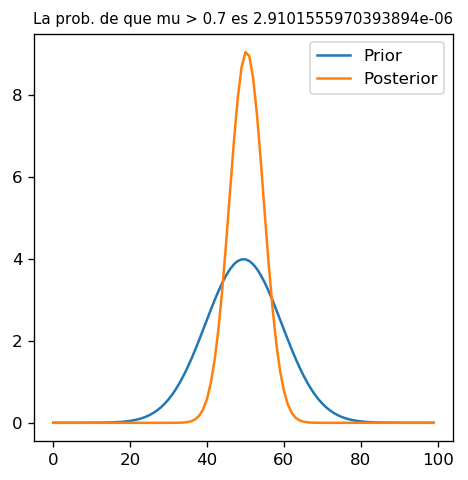

In [4]:
import numpy as np
from scipy.stats import binom, norm

import matplotlib.pylab as plt

def inferencia_moneda(tiradas, seed=123):
    """Realiza inferencia bayesiana en el parametro mu de una moneda.

    Input:
    tiradas -- Resultado de N tiradas (VECTOR)
    seed    -- Semilla para np.random (default=123)

    Output:
    p        -- probabilidad de que mu>0.7
    posterior-- posterior de mu, shape=(100,)
    """
    np.random.seed(seed)
    mu, step = np.linspace(0, 1, num=100, retstep=True) #step es el espacio entre puntos
    #Numero de tiradas, y de veces que salio cara
    N = len(tiradas)
    X = np.sum(tiradas)

    #Start
    prior = norm(loc=0.5, scale=0.1).pdf(mu) #Esto es el prior evaluado en el vector mu
    
    verosimilitud = binom.pmf(k=X, n=N, p=mu)  #La verosimilitud evaluada en el vector mu
    posterior = prior*verosimilitud #el posterior no normalizado
    evidencia = posterior.sum()/len(mu) #evidencia o verosimilitud marginalizada
    posterior = posterior/evidencia #normalizamos para obtener el posterior
    p = np.sum(posterior[mu>0.7])/len(mu) #Probabilidad de que mu > 0.7 
    
    fig = plt.figure(figsize=(4.5,4.5),dpi=120)
    plt.plot(prior, label='Prior')
    plt.plot(posterior, label='Posterior')
    plt.legend()
    plt.title(r'La prob. de que mu > 0.7 es {}'.format(p),fontsize=9)
    plt.show()

    #Finish
    assert len(posterior) == len(mu), "Tamaño del posterior distinto al de mu"
    return p, np.array(posterior)

#from scipy.stats import bernoulli
#mu_true = 0.5 # Se cree que es fair
#N = 100
#tiradas = bernoulli.rvs(mu_true, size=N)
#p, pos = inferencia_moneda(tiradas,123)


## 3. Regresión Lineal

Construye una función que dado un input (X_train, Y_train) realice un ajuste lineal de cuadrados mínimos, y con ello devuelva las predicciones para el input X_test como un vector Y_test.

Por favor, utilice el siguiente signature. Se recomienda cambiar el código solamente entre los comentarios "Start" y "Finish". 
Si quiere probar cosas, siéntase libre de crear nuevas celdas de código, aunque estas no serán evaluadas.

<b>Ayuda</b>: pueden usar la implementación de las ecuaciones normales que aparece en el notebook de [modelos lineales](05_ModelosLineales.ipynb) o las clases del módulo <tt>sklearn.linear_model</tt>.

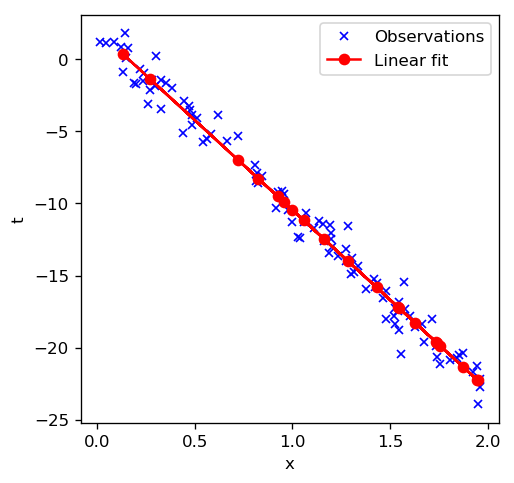

In [13]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

def ajuste_lineal(X_train, Y_train, X_test):
    """Calcula un ajuste lineal.

      Input:
      X_train -- datos de entrenamiento, shape=(N,1)
      Y_train -- etiquetas de entrenamiento, shape=(N,1)
      X_test  -- datos de testeo, shape=(N_test,1)

      Output:
      Y_test  -- prediccion de etiquetas para X_test, shape=(N_test,1)
      """

    N = len(X_train)
    N_test = len(X_test)
    #Start
    reg = LinearRegression()
    reg.fit(X_train, Y_train)
    #ahora guardamos los resultados en esta variable
    Y_test = reg.predict(X_test)
    #Finish
    assert len(Y_test) == len(X_test), "Tamaño de Y_test distinto al de X_test"
    return np.array(Y_test)

#N  = 100
#slope  = -4*np.pi; inter  =  2
#x_true = 2 * np.random.rand(N, 1) # True
#t_true = inter + slope * x_true   # True
#t_true += np.random.randn(N, 1)   # add normal error
#
#data = np.hstack([x_true, t_true])
#train, test = train_test_split(data, test_size=0.2, random_state=1234)
#
#X_train = train[:,0].reshape((len(train),1))
#y_train = train[:,1].reshape((len(train),1))
#X_test  = test[:,0].reshape((len(test),1))
#y_test  = test[:,1].reshape((len(test),1))
#
#y_pred = ajuste_lineal(X_train, y_train, X_test)
#
#fig = plt.figure(figsize=(4.5,4.5),dpi=120)
#
##plt.title(r'La prob. de que mu > 0.7 es {}'.format(p),fontsize=9)
#plt.plot(x_true, t_true, 'xb', label='Observations', ms=5, zorder=-5)
#plt.plot(X_test, y_pred, '-or', label='Linear fit', ms=6)
#
#plt.xlabel('x')
#plt.ylabel('t')
#plt.legend(loc='best')
#plt.show()
